In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training import *
from helpers.visualizations import *
from helpers.preprocessing import *
from helpers.aequitas_methods import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import warnings
from sklearn.preprocessing import MinMaxScaler
from helpers.mitigation_methods import *
from aequitas import Audit
warnings.filterwarnings(action='ignore')

#### open ml id : 44096

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[inFairness]'


In [2]:
df = pd.read_csv("dataset/german_credit.csv")
df['target'] = np.where(df['target']==2,0,1)
df = df.drop(columns = ['Unnamed: 0'], axis=1)
def categorize_age(age):
    if age<35:
        return '<=35'
    if age>=35:
        return '>35'
df['age'] = df['age'].apply(categorize_age).astype(object)
df['age'].value_counts()

protected_attributes = ["housing","gender","num_people_maintenance"]
target = 'target'

df["housing"] = np.where(df['housing']=="own","own","not own")


In [3]:
categorical_attributes = get_categorical_attributes(df)
df_num = df.copy()
encode_categorical_attributes(df_num, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num.columns:
    if col not in categorical_attributes and df_num[col].dtypes == "int64":
        df_num[col] = scaler.fit_transform(df_num[[col]])

df_num["num_people_maintenance"] = df_num["num_people_maintenance"].astype(int)

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'gender', 'other_debtors', 'property', 'age', 'installment_plans', 'housing', 'job', 'phone', 'foreigner']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: other_debtors
{'co-applicant': 0, 'guarantor': 1, 'none

In [4]:
"""
num_people_maintenance: Number of people being liable to provide maintenance for
housing: Type of housing, either owning or not (free & rent attributes are combined together)
"""

df_intersect = df.copy()

df_intersect["num_people_maintenance/gender"] = df_intersect["num_people_maintenance"].astype(str)+ "-" + df_intersect["gender"]
df_intersect["gender/housing"] = df_intersect["gender"] + "-" + df_intersect["housing"]
df_intersect["num_people_maintenance/housing"] = df_intersect["num_people_maintenance"].astype(str) + "-" + df_intersect["housing"]
df_intersect.drop(protected_attributes, axis=1, inplace=True)

protected_attributes_int = ["num_people_maintenance/gender","gender/housing","num_people_maintenance/housing"]

categorical_attributes = get_categorical_attributes(df_intersect)
df_num_int = df_intersect.copy()
encode_categorical_attributes(df_num_int, categorical_attributes)
scaler = MinMaxScaler()

for col in df_num_int.columns:
    if col not in categorical_attributes and df_num_int[col].dtypes == "int64":
        df_num_int[col] = scaler.fit_transform(df_num_int[[col]])

['acc_status', 'credit_history', 'purpose', 'savings_acc', 'employment_time', 'other_debtors', 'property', 'age', 'installment_plans', 'job', 'phone', 'foreigner', 'num_people_maintenance/gender', 'gender/housing', 'num_people_maintenance/housing']
Attribute: acc_status
{'dm_0_to_200': 0, 'dm_greater_eq_200': 1, 'dm_less_than_0': 2, 'no_acc': 3}
Attribute: credit_history
{'credit_paid_so_far': 0, 'critical_amount': 1, 'delay_in_past_credit_payment': 2, 'no_credit_all': 3, 'no_credit_this_bank': 4}
Attribute: purpose
{'business': 0, 'car_new': 1, 'car_old': 2, 'domestic_appliances': 3, 'education': 4, 'furniture_or_equipment': 5, 'other': 6, 'radio_or_tv': 7, 'repairs': 8, 'retraining': 9}
Attribute: savings_acc
{'dm_100_to_500': 0, 'dm_500_to_1000': 1, 'dm_greater_eq_1000': 2, 'dm_less_100': 3, 'unknown_or_no_savings': 4}
Attribute: employment_time
{'four_to_seven': 0, 'greater_eq_seven': 1, 'less_one': 2, 'one_to_four': 3, 'unemployed': 4}
Attribute: other_debtors
{'co-applicant': 0, 

<Axes: >

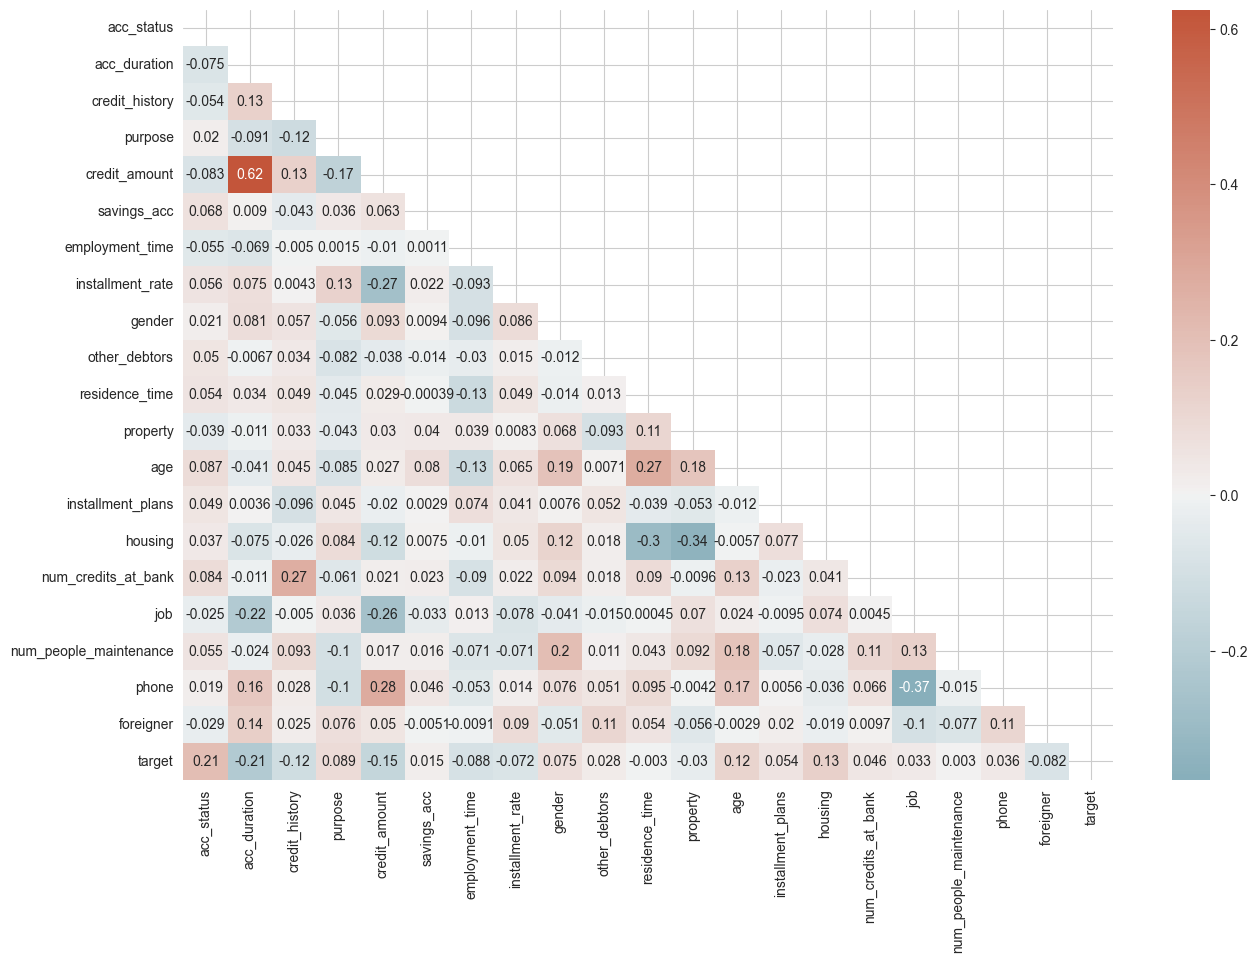

In [16]:
corr = df_num.corr()
below_main_diagonal = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
mask = pd.isna(below_main_diagonal) 
plt.figure(figsize=(15, 10))
sns.heatmap(below_main_diagonal.fillna(0),
            annot=True, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True), 
            center=0, 
            mask=mask,
            vmin=below_main_diagonal.min().min(), 
            vmax=below_main_diagonal.max().max())

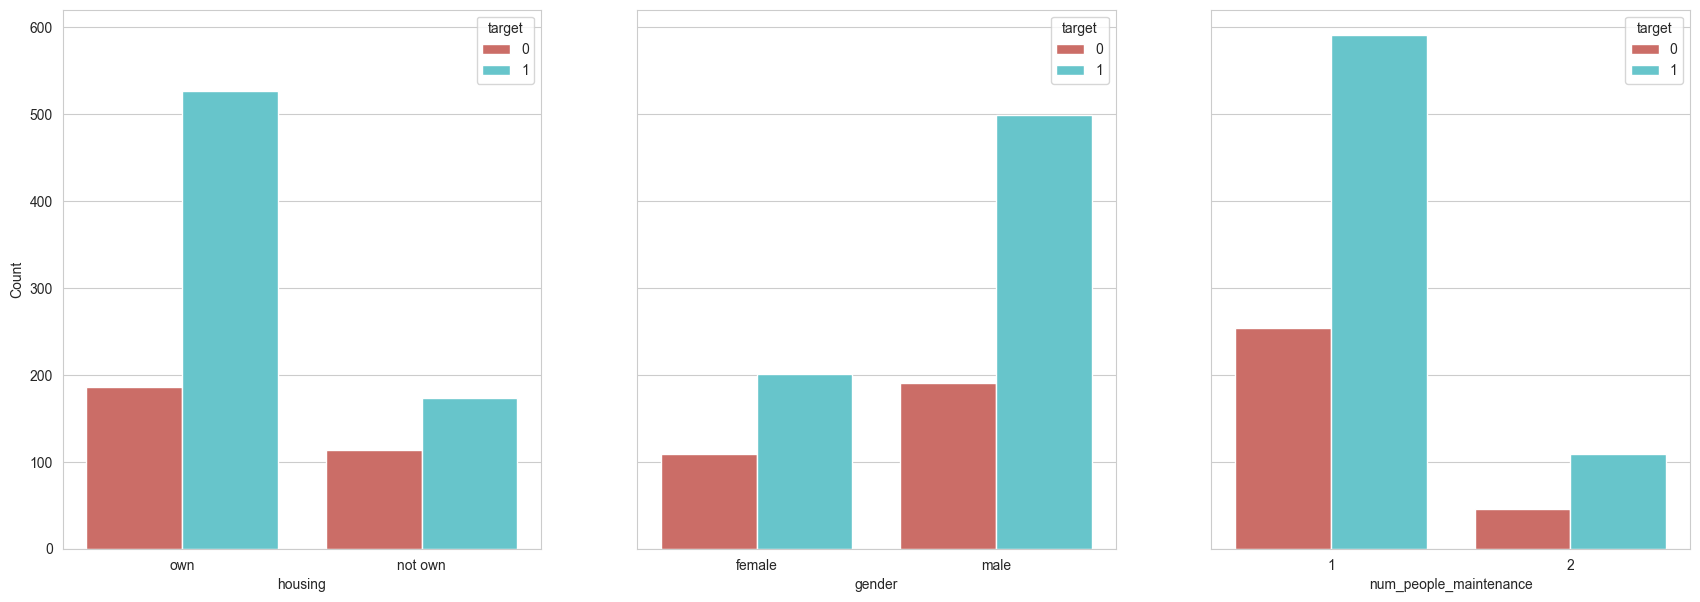

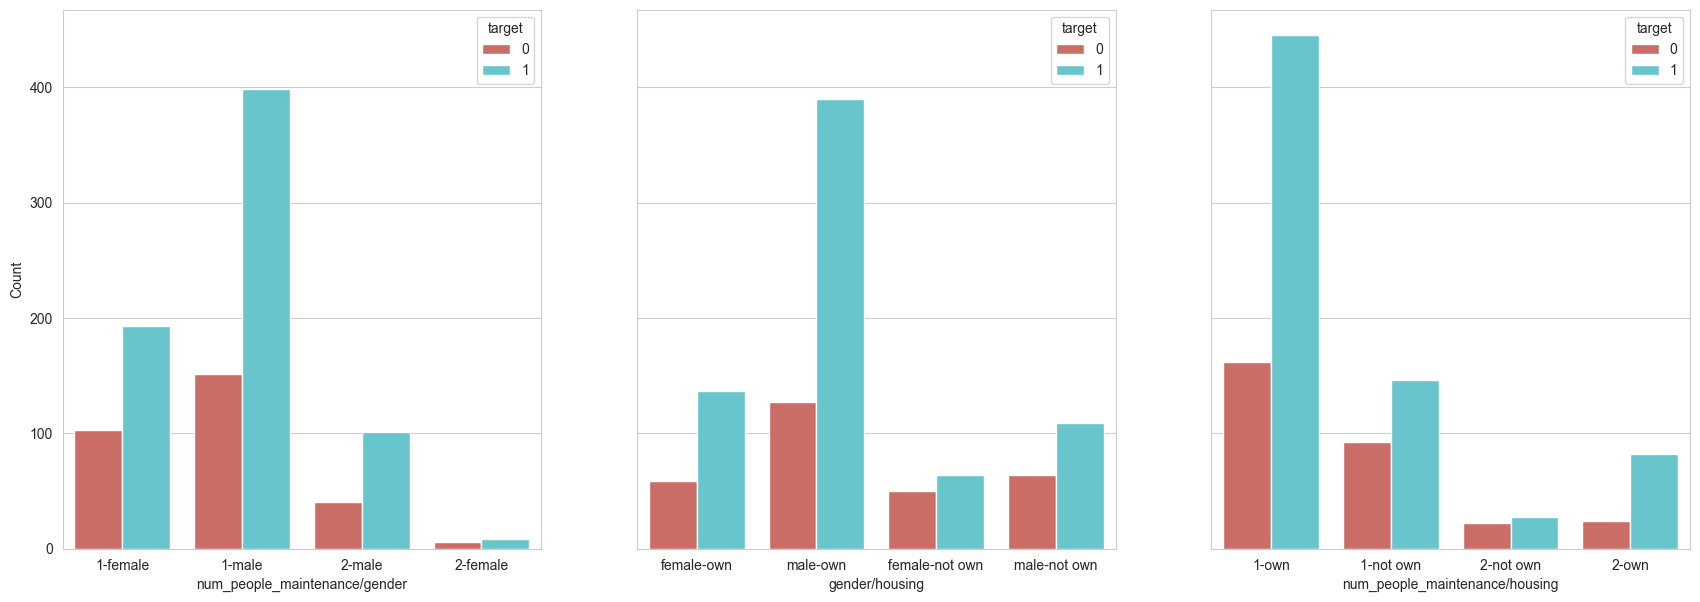

In [31]:
import math
def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(4, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)
plot_attributes(df_intersect, protected_attributes_int)

In [5]:
def split_and_train(data, attributes):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    models = {"Catboost",
                  "LogisticRegression",
                  "RandomForest",
                  "DecisionTree"
                  }
    y_predicted_dict = {}
    metrics_dict = {}
    for m in models:
            model = choose_model(m, x_train, y_train)
            y_predicted =  evaluate_model(model, x_train, x_test, y_train, y_test)
            attribute_metrics  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_predicted,attributes=attributes, target=target)
            metrics_dict[m] = attribute_metrics
            y_predicted_dict[m] = y_predicted
            print(f"Classification report for model: {model} : \n {classification_report(y_test, y_predicted)}")
            # plot_roc_curve(y_true=y_test, y_pred=y_predicted, model_name=m)
    return x_test, y_test, y_predicted_dict, metrics_dict

def plot_audit(dataset, attributes):
    audit = Audit(dataset[['score','label_value']+attributes])
    summary = audit.summary_plot(["tpr","fpr","fnr","tnr","pprev"])
    summary.show()

In [6]:
"""
Train and calculate fairness metrics for original dataset.
"""
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df_num,protected_attributes)
df_test = calc_fairness_report(x_test, y_test, y_predicted_dict['RandomForest'], target, protected_attributes)

---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 60 candidates, totalling 300 fits
DecisionTreeClassifier(max_depth=3, min_samples_leaf=60)
Accuracy score training:
0.7238
Accuracy score test:
0.7350
----------------------------------------

Privileged groups:  [{'housing': 1}]
Unprivileged groups:  [{'housing': 0}]
Disparate Impact Ratio for housing: 0.959
Statistical Parity Difference for housing: -0.038


Privileged groups:  [{'gender': 1}]
Unprivileged groups:  [{'gender': 0}]
Disparate Impact Ratio for gender: 1.003
Statistical Parity Difference for gender: 0.002


Privileged groups:  [{'num_people_maintenance': 0}]
Unprivileged groups:  [{'num_people_maintenance': 1}]
Disparate Impact Ratio for num_people_maintenance: 1.014
Statistical Parity Difference for num_people_maintenance: 0.013


Classification report for model: DecisionTreeClassifier(max_depth=3, min_samples_leaf=60) : 
               precision    recall  f1-score   support

           0     

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,housing,0,0.70,0.97,0.35,0.11,0.34,0.65,0.03,0.89,0.66,0.24,0.83,0.57
1,housing,1,0.78,0.97,0.06,0.60,0.20,0.94,0.03,0.40,0.80,0.76,0.97,0.79
2,gender,0,0.80,0.98,0.39,0.12,0.21,0.61,0.02,0.88,0.79,0.28,0.87,0.70
3,gender,1,0.74,0.97,0.08,0.50,0.25,0.92,0.03,0.50,0.75,0.72,0.96,0.74
4,num_people_maintenance,0,0.76,0.97,0.19,0.31,0.24,0.81,0.03,0.69,0.76,0.86,0.92,0.73
5,num_people_maintenance,1,0.78,1.00,0.14,0.00,0.23,0.86,0.00,1.00,0.77,0.14,0.96,0.74


Majority class for:  housing  is: 1
Majority class for:  gender  is: 1
Majority class for:  num_people_maintenance  is: 0
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,housing,0,1.67,1.29,0.19,0.70,2.22,0.31,0.86,0.83,...,False,False,False,False,False,False,False,False,False,False
1,housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,gender,0,0.86,0.83,0.25,0.67,1.75,0.39,0.91,1.05,...,False,False,False,False,False,False,False,False,False,False
3,gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
4,num_people_maintenance,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
5,num_people_maintenance,1,0.97,0.00,0.00,1.06,1.44,0.16,1.04,1.01,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender,False,True,True,False,False,True,True,False,False,True,False,False,False,False,False
1,0,binary 0/1,housing,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance,False,True,True,True,False,False,True,False,False,True,True,False,True,False,False


In [7]:
"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_num_int,protected_attributes_int)
df_test_int = calc_fairness_report(x_test_int, y_test_int, y_predicted_dict_int['RandomForest'], target, protected_attributes_int)

---------- Model name:  DecisionTree ----------

Fitting 5 folds for each of 60 candidates, totalling 300 fits
DecisionTreeClassifier(max_depth=3, min_samples_leaf=60)
Accuracy score training:
0.7238
Accuracy score test:
0.7350
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 1.003
Statistical Parity Difference for num_people_maintenance/gender: 0.003


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.955
Statistical Parity Difference for gender/housing: -0.042


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maintenance/housin

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.81,0.98,0.41,0.12,0.20,0.59,0.02,0.88,0.80,0.27,0.86,0.70
1,num_people_maintenance/gender,1,0.72,0.94,0.10,0.62,0.25,0.90,0.06,0.38,0.75,0.59,0.93,0.74
2,num_people_maintenance/gender,2,0.67,1.00,0.00,NaN,0.33,1.00,0.00,NaN,0.67,0.02,1.00,0.67
3,num_people_maintenance/gender,3,0.79,1.00,0.17,0.00,0.22,0.83,0.00,1.00,0.78,0.13,0.96,0.75
4,gender/housing,0,0.80,1.00,0.56,0.00,0.27,0.44,0.00,1.00,0.73,0.08,0.75,0.55
5,gender/housing,1,0.80,0.97,0.22,0.33,0.19,0.78,0.03,0.67,0.81,0.20,0.92,0.78
6,gender/housing,2,0.64,0.95,0.21,0.25,0.38,0.79,0.05,0.75,0.62,0.16,0.88,0.58
7,gender/housing,3,0.77,0.95,0.05,0.80,0.21,0.95,0.05,0.20,0.79,0.56,0.95,0.79
8,num_people_maintenance/housing,0,0.70,0.96,0.35,0.12,0.33,0.65,0.04,0.88,0.67,0.21,0.83,0.57
9,num_people_maintenance/housing,1,0.77,0.95,0.11,0.62,0.20,0.89,0.05,0.38,0.80,0.64,0.94,0.79


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.82,0.43,0.20,0.65,2.33,0.45,0.92,1.06,...,False,True,True,False,True,False,False,False,False,True
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,1.33,0.00,NaN,1.11,NaN,0.03,1.07,0.89,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,0.87,0.00,0.00,0.93,2.67,0.21,1.03,1.04,...,False,None,None,False,None,False,False,False,False,None
4,gender/housing,0,1.30,0.00,0.00,0.47,5.00,0.15,0.79,0.92,...,False,True,True,False,True,False,False,False,False,True
5,gender/housing,1,0.92,0.69,0.42,0.81,3.33,0.36,0.97,1.02,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,1.84,1.12,0.31,0.82,3.75,0.28,0.92,0.78,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,None,None,False,None,False,False,False,False,None
8,num_people_maintenance/housing,0,1.64,0.73,0.20,0.73,2.33,0.33,0.89,0.84,...,False,True,True,False,True,False,False,False,False,True
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/housing,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/housing,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False


In [8]:
plot_audit(df_test, protected_attributes)
plot_audit(df_test_int, protected_attributes_int)

alt.VConcatChart(...)

alt.VConcatChart(...)

# Bias mitigation methods

In [35]:
protected_attributes_int

['num_people_maintenance/gender',
 'gender/housing',
 'num_people_maintenance/housing']

In [37]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_m1 = pre_process_massaging(data_to_transform, "num_people_maintenance/gender",target)
data_transformed_m1["num_people_maintenance/gender"] = data_transformed_m1["num_people_maintenance/gender"].astype(int)
data_transformed_m2 = pre_process_massaging(data_transformed_m1, "gender/housing",target)
data_transformed_m2["gender/housing"] = data_transformed_m2["gender/housing"].astype(int)
data_transformed_m3= pre_process_massaging(data_transformed_m2, "num_people_maintenance/housing",target)
data_transformed_m3["num_people_maintenance/housing"] = data_transformed_m3["num_people_maintenance/housing"].astype(int)

#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_transformed_m3,protected_attributes_int)
#calculate the fairness report
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["RandomForest"],target,protected_attributes_int)

plot_audit(df_test_int,protected_attributes_int)
plot_audit(df_test_transformed,protected_attributes_int)


---------- Model name:  RandomForest ----------

Accuracy score training:
0.8612
Accuracy score test:
0.8500
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 0.968
Statistical Parity Difference for num_people_maintenance/gender: -0.027


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.891
Statistical Parity Difference for gender/housing: -0.095


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maintenance/housing': 3}, {'num_people_maintenance/housing': 0}]
Disparate Impact Ratio for num_people_maintenance/housing: 0.875
Statis

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.88,0.95,0.67,0.17,0.11,0.33,0.05,0.83,0.89,0.27,0.79,0.74
1,num_people_maintenance/gender,1,0.84,0.99,0.50,0.05,0.19,0.50,0.01,0.95,0.81,0.59,0.84,0.69
2,num_people_maintenance/gender,2,1.00,1.00,NaN,NaN,0.00,NaN,0.00,NaN,1.00,0.02,1.00,1.00
3,num_people_maintenance/gender,3,0.83,0.94,0.50,0.25,0.15,0.50,0.06,0.75,0.85,0.12,0.83,0.75
4,gender/housing,0,0.90,0.92,0.86,0.14,0.08,0.14,0.08,0.86,0.92,0.08,0.65,0.65
5,gender/housing,1,0.88,0.97,0.50,0.20,0.11,0.50,0.03,0.80,0.89,0.21,0.88,0.80
6,gender/housing,2,0.79,0.90,0.58,0.22,0.21,0.42,0.10,0.78,0.79,0.15,0.73,0.64
7,gender/housing,3,0.85,1.00,0.47,0.00,0.17,0.53,0.00,1.00,0.83,0.56,0.87,0.72
8,num_people_maintenance/housing,0,0.85,0.93,0.71,0.14,0.15,0.29,0.07,0.86,0.85,0.20,0.70,0.64
9,num_people_maintenance/housing,1,0.85,0.99,0.47,0.06,0.17,0.53,0.01,0.94,0.83,0.66,0.87,0.73


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.60,3.81,3.17,0.67,0.88,0.46,0.94,1.09,...,False,False,False,False,False,True,True,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,0.00,0.00,NaN,NaN,NaN,0.03,1.20,1.23,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,0.81,4.44,4.75,1.00,0.79,0.21,1.00,1.04,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,0.45,10.00,10.00,0.27,0.86,0.14,0.75,1.11,...,False,False,False,False,False,True,True,False,False,False
5,gender/housing,1,0.66,10.00,10.00,0.94,0.80,0.38,1.01,1.07,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,1.21,10.00,10.00,0.78,0.78,0.26,0.84,0.96,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,NaN,NaN,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,0.92,6.13,2.43,0.56,0.91,0.30,0.81,1.02,...,False,False,False,False,False,True,True,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/housing,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
1,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/housing,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [38]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_num_int.copy()
data_transformed_ps1 = pre_process_prev_sampling(data_to_transform, "num_people_maintenance/gender",target)
data_transformed_ps1["num_people_maintenance/gender"] = data_transformed_ps1["num_people_maintenance/gender"].astype(int)
data_transformed_ps2 = pre_process_prev_sampling(data_transformed_ps1, "gender/housing",target)
data_transformed_ps2["gender/housing"] = data_transformed_ps2["gender/housing"].astype(int)
data_transformed_ps3= pre_process_prev_sampling(data_transformed_ps2, "num_people_maintenance/housing",target)
data_transformed_ps3["num_people_maintenance/housing"] = data_transformed_ps3["num_people_maintenance/housing"].astype(int)

#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps3,protected_attributes_int)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["RandomForest"],target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_ps, protected_attributes_int)

[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Original group 0 size: 296


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 296


[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Final group 0 size: 276


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 276


[INFO] 2024-09-04 10:01:09 methods.preprocessing.PrevalenceSampling - Original group 1 size: 549


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 549


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 1 size: 503


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 503


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 3 size: 141


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 141


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 3 size: 133


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 133


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 2 size: 14


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 14


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 2 size: 11


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 11


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 1 size: 182


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 182


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 1 size: 150


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 150


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 3 size: 474


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 474


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 3 size: 423


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 423


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 0 size: 105


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 105


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 0 size: 91


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 91


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 2 size: 162


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 162


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 2 size: 140


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 140


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Fitting sampling method.


INFO:methods.preprocessing.PrevalenceSampling:Fitting sampling method.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Sampling method fitted.


INFO:methods.preprocessing.PrevalenceSampling:Sampling method fitted.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 1 size: 485


INFO:methods.preprocessing.PrevalenceSampling:Original group 1 size: 485


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 1 size: 480


INFO:methods.preprocessing.PrevalenceSampling:Final group 1 size: 480


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 0 size: 195


INFO:methods.preprocessing.PrevalenceSampling:Original group 0 size: 195


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 0 size: 193


INFO:methods.preprocessing.PrevalenceSampling:Final group 0 size: 193


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 3 size: 88


INFO:methods.preprocessing.PrevalenceSampling:Original group 3 size: 88


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 3 size: 77


INFO:methods.preprocessing.PrevalenceSampling:Final group 3 size: 77


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Original group 2 size: 36


INFO:methods.preprocessing.PrevalenceSampling:Original group 2 size: 36


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Final group 2 size: 36


INFO:methods.preprocessing.PrevalenceSampling:Final group 2 size: 36


[INFO] 2024-09-04 10:01:10 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


---------- Model name:  RandomForest ----------

Accuracy score training:
0.8089
Accuracy score test:
0.7468
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 0.977
Statistical Parity Difference for num_people_maintenance/gender: -0.022


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.941
Statistical Parity Difference for gender/housing: -0.056


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maintenance/housing': 3}, {'num_people_maintenance/housing': 0}]
Disparate Impact Ratio for num_people_maintenance/housing: 1.045
Statis

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.65,0.91,0.12,0.60,0.33,0.88,0.09,0.40,0.67,0.31,0.90,0.67
1,num_people_maintenance/gender,1,0.76,0.97,0.14,0.40,0.23,0.86,0.03,0.60,0.77,0.54,0.94,0.75
2,num_people_maintenance/gender,2,1.00,1.00,NaN,NaN,0.00,NaN,0.00,NaN,1.00,0.01,1.00,1.00
3,num_people_maintenance/gender,3,0.90,1.00,0.33,0.00,0.10,0.67,0.00,1.00,0.90,0.14,0.95,0.86
4,gender/housing,0,0.67,1.00,0.00,NaN,0.33,1.00,0.00,NaN,0.67,0.14,1.00,0.67
5,gender/housing,1,0.66,0.86,0.20,0.60,0.30,0.80,0.14,0.40,0.70,0.18,0.84,0.69
6,gender/housing,2,0.87,1.00,0.43,0.00,0.15,0.57,0.00,1.00,0.85,0.18,0.90,0.77
7,gender/housing,3,0.76,0.97,0.06,0.67,0.22,0.94,0.03,0.33,0.78,0.49,0.96,0.77
8,num_people_maintenance/housing,0,0.74,1.00,0.15,0.00,0.27,0.85,0.00,1.00,0.73,0.28,0.95,0.70
9,num_people_maintenance/housing,1,0.71,0.93,0.12,0.62,0.26,0.88,0.07,0.38,0.74,0.57,0.91,0.73


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,1.43,2.78,1.5,1.03,0.67,0.58,0.96,0.87,...,False,False,False,False,False,False,False,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,0.00,0.00,NaN,NaN,NaN,0.03,1.06,1.30,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,0.44,0.00,0.0,0.78,1.67,0.25,1.01,1.17,...,False,None,None,False,None,False,False,False,False,None
4,gender/housing,0,1.50,0.00,NaN,1.06,NaN,0.29,1.04,0.86,...,False,False,False,False,False,False,False,False,False,False
5,gender/housing,1,1.33,3.95,0.9,0.85,1.20,0.38,0.88,0.90,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,0.67,0.00,0.0,0.61,3.00,0.38,0.94,1.10,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,...,False,None,None,False,None,False,False,False,False,None
8,num_people_maintenance/housing,0,1.02,0.00,0.0,0.96,2.67,0.49,1.04,0.99,...,False,False,False,False,False,False,False,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/housing,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
1,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/housing,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

TypeError: plot_metrics() missing 1 required positional argument: 'attribute'

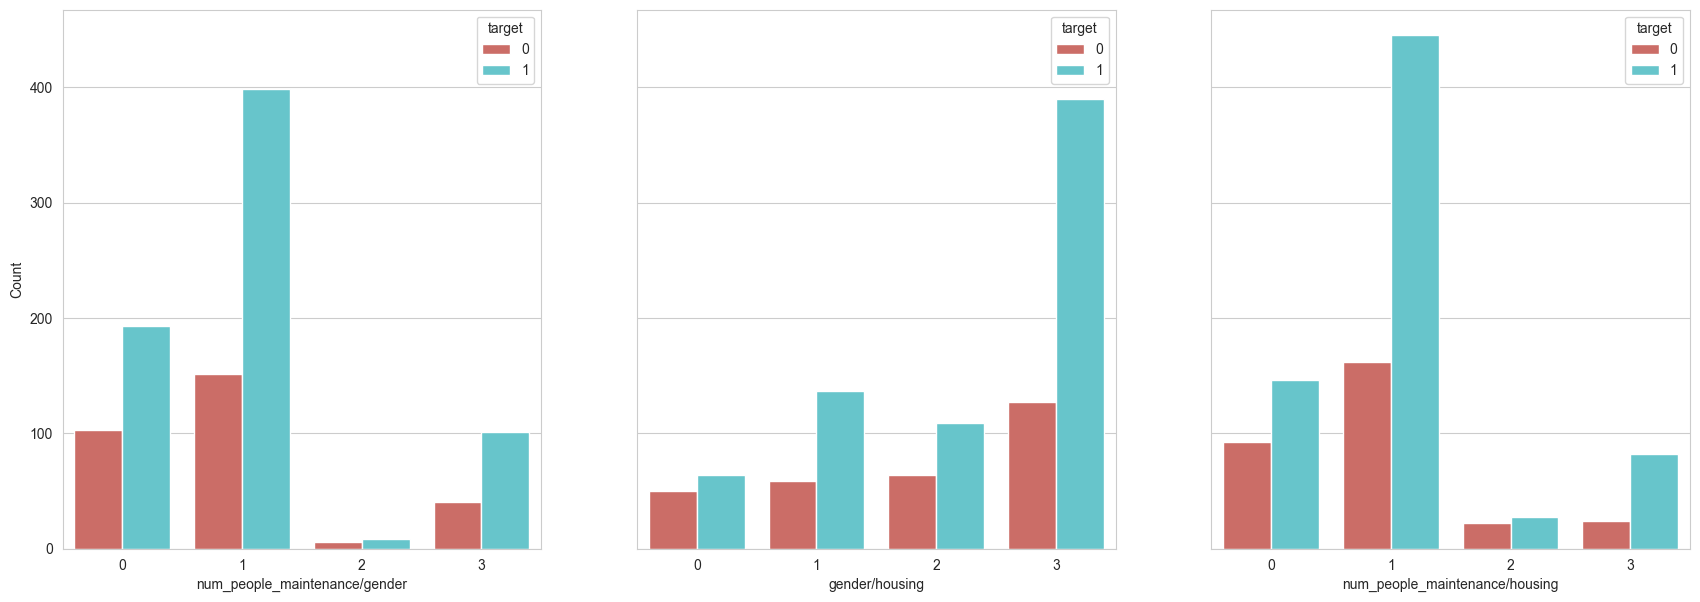

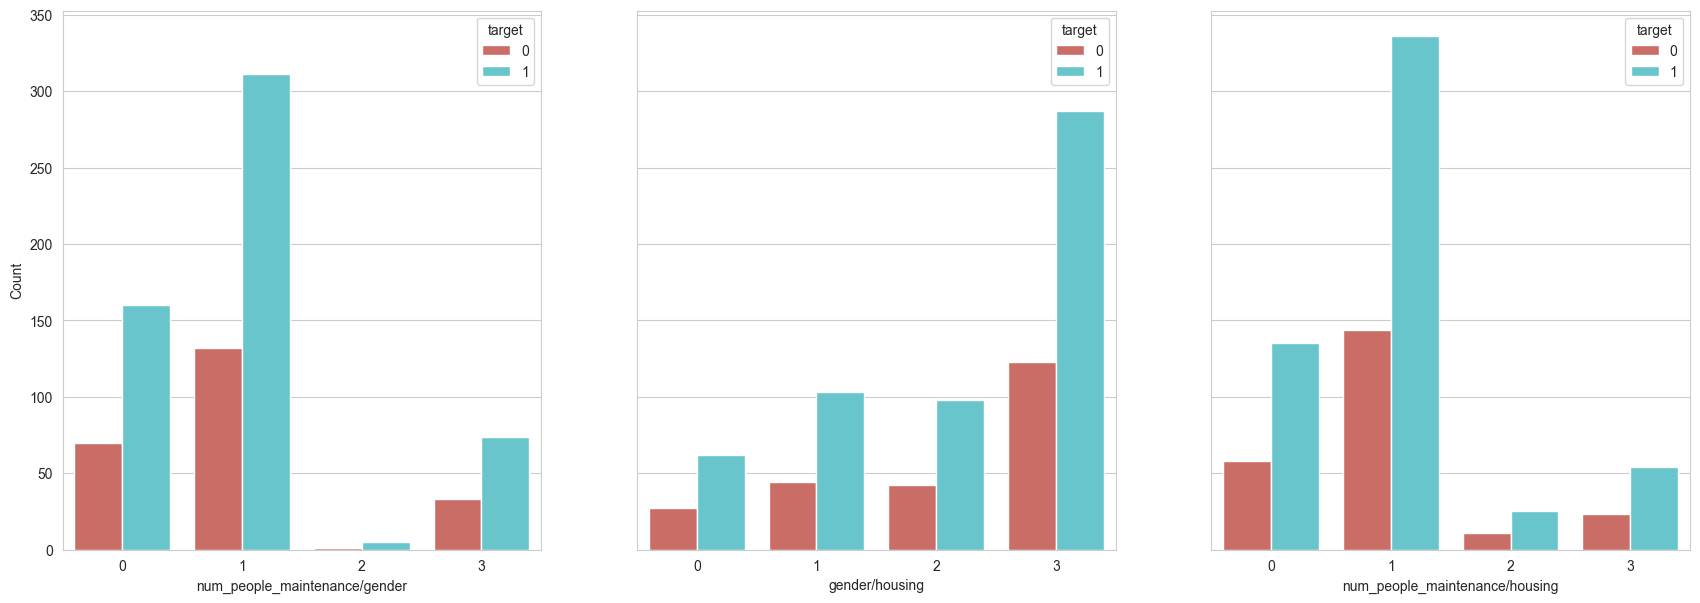

In [41]:
plot_attributes(df_num_int,protected_attributes_int)

plot_attributes(data_transformed_ps3,protected_attributes_int)


In [43]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''

#transform data
data_to_transform = df_num_int.copy()
columns_to_change = df_num_int.columns.difference(protected_attributes_int).tolist()
columns_to_change.remove(target)
data_transformed_dr1 = pre_process_data_repairer(data_to_transform, 'num_people_maintenance/gender',target,columns_to_change)
data_transformed_dr2 = pre_process_data_repairer(data_transformed_dr1, 'gender/housing',target,columns_to_change)
data_transformed_dr3 = pre_process_data_repairer(data_transformed_dr2, 'num_people_maintenance/housing',target,columns_to_change)
data_transformed_dr3['num_people_maintenance/gender'] = data_transformed_dr3['num_people_maintenance/gender'].astype(int)
data_transformed_dr3['gender/housing'] = data_transformed_dr3['gender/housing'].astype(int)
data_transformed_dr3['num_people_maintenance/housing'] = data_transformed_dr3['num_people_maintenance/housing'].astype(int)

#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_transformed_dr3,protected_attributes_int)

#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["RandomForest"],target,protected_attributes_int)

#compare disparities
plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_dr, protected_attributes_int)


---------- Model name:  RandomForest ----------

Accuracy score training:
0.7913
Accuracy score test:
0.7350
----------------------------------------

Privileged groups:  [{'num_people_maintenance/gender': 1}]
Unprivileged groups:  [{'num_people_maintenance/gender': 2}, {'num_people_maintenance/gender': 3}, {'num_people_maintenance/gender': 0}]
Disparate Impact Ratio for num_people_maintenance/gender: 0.985
Statistical Parity Difference for num_people_maintenance/gender: -0.014


Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.957
Statistical Parity Difference for gender/housing: -0.041


Privileged groups:  [{'num_people_maintenance/housing': 1}]
Unprivileged groups:  [{'num_people_maintenance/housing': 2}, {'num_people_maintenance/housing': 3}, {'num_people_maintenance/housing': 0}]
Disparate Impact Ratio for num_people_maintenance/housing: 1.013
Statis

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.75,0.95,0.29,0.29,0.24,0.71,0.05,0.71,0.76,0.27,0.88,0.70
1,num_people_maintenance/gender,1,0.72,0.94,0.10,0.62,0.25,0.90,0.06,0.38,0.75,0.58,0.93,0.74
2,num_people_maintenance/gender,2,0.67,1.00,0.00,NaN,0.33,1.00,0.00,NaN,0.67,0.02,1.00,0.67
3,num_people_maintenance/gender,3,0.75,1.00,0.00,NaN,0.25,1.00,0.00,NaN,0.75,0.13,1.00,0.75
4,gender/housing,0,0.70,1.00,0.33,0.00,0.35,0.67,0.00,1.00,0.65,0.09,0.85,0.55
5,gender/housing,1,0.78,0.94,0.22,0.50,0.19,0.78,0.06,0.50,0.81,0.19,0.90,0.78
6,gender/housing,2,0.58,0.95,0.07,0.50,0.42,0.93,0.05,0.50,0.58,0.17,0.94,0.58
7,gender/housing,3,0.78,0.95,0.09,0.67,0.20,0.91,0.05,0.33,0.80,0.55,0.94,0.79
8,num_people_maintenance/housing,0,0.64,0.96,0.20,0.20,0.38,0.80,0.04,0.80,0.62,0.23,0.89,0.57
9,num_people_maintenance/housing,1,0.77,0.94,0.15,0.60,0.20,0.85,0.06,0.40,0.80,0.63,0.92,0.79


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.96,0.86,0.46,0.78,1.9,0.46,0.94,1.01,...,True,False,False,True,False,False,False,True,True,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,1.33,0.00,NaN,1.11,NaN,0.03,1.07,0.89,...,False,None,None,False,None,False,False,False,False,None
3,num_people_maintenance/gender,3,1.00,0.00,NaN,1.11,NaN,0.22,1.07,1.00,...,False,None,None,False,None,False,False,False,False,None
4,gender/housing,0,1.78,0.00,0.00,0.73,3.0,0.17,0.90,0.81,...,True,False,False,True,False,False,False,True,True,False
5,gender/housing,1,0.98,1.37,0.75,0.86,1.5,0.36,0.95,1.00,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,2.12,1.12,0.75,1.02,1.5,0.31,1.00,0.72,...,False,None,None,False,None,False,False,False,False,None
7,gender/housing,3,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,...,False,None,None,False,None,False,False,False,False,None
8,num_people_maintenance/housing,0,1.92,0.61,0.33,0.94,2.0,0.36,0.97,0.77,...,True,False,False,True,False,False,False,True,True,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/housing,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
1,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/housing,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [50]:
from aequitas.flow.methods.inprocessing import FairlearnClassifier

'''
In-processing: Fair learn classifier 
'''
def train_with_fairlearn(data, attribute, model, metrics_dict):
    y = data.loc[:, target]
    x = data.drop(target, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
    s_train = x_train[attribute]
    x_train = x_train.drop(columns= [attribute], axis=1)
    s_test = x_test[attribute]
    x_test = x_test.drop(columns= [attribute], axis=1)
    
    fairlearn_clf = FairlearnClassifier(estimator=model, constraint="fairlearn.reductions.DemographicParity",reduction='fairlearn.reductions.ExponentiatedGradient')
    
    fairlearn_clf.fit(x_train, y_train, s_train) 
    y_train_pred = fairlearn_clf.predict_proba(x_train,s_train).astype(int)
    y_test_pred = fairlearn_clf.predict_proba(x_test,s_test).astype(int)
    x_test.insert(len(x_test.columns)-1,attribute,s_test,True) # insert back the attribute
    print("Model:\n", model)
    print(f"Accuracy score training:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Accuracy score test:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Classification report for model: {model} : \n {classification_report(y_test, y_test_pred)}")
    metric  = calc_metrics(x_test=x_test,y_test=y_test,y_predicted=y_test_pred,attributes=[attribute], target=target)
    metrics_dict[model] =metric
    return x_test, y_test, y_test_pred, metrics_dict


data_to_transform = df_num_int.copy()
models = ["sklearn.ensemble.RandomForestClassifier"]
metrics_dict = {}
x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform, "gender/housing", models[0], metrics_dict)


[INFO] 2024-09-04 10:30:12 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.ensemble._forest.RandomForestClassifier'>' with parameters: {}.


[INFO] 2024-09-04 10:30:12 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.DemographicParity'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.DemographicParity'>' with parameters: {}.


[INFO] 2024-09-04 10:30:12 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.ensemble.RandomForestClassifier
Accuracy score training:
1.0000
Accuracy score test:
0.7400
Classification report for model: sklearn.ensemble.RandomForestClassifier : 
               precision    recall  f1-score   support

           0       0.52      0.44      0.48        54
           1       0.81      0.85      0.83       146

    accuracy                           0.74       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.73      0.74      0.73       200

Privileged groups:  [{'gender/housing': 3}]
Unprivileged groups:  [{'gender/housing': 0}, {'gender/housing': 2}, {'gender/housing': 1}]
Disparate Impact Ratio for gender/housing: 0.840
Statistical Parity Difference for gender/housing: -0.133




In [52]:
df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int)

plot_audit(df_test_int, protected_attributes_int)
plot_audit(df_test_transformed_fl, protected_attributes_int)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,num_people_maintenance/gender,0,0.70,0.75,0.59,0.50,0.19,0.41,0.25,0.50,0.81,0.24,0.65,0.70
1,num_people_maintenance/gender,1,0.74,0.87,0.37,0.50,0.20,0.63,0.13,0.50,0.80,0.61,0.81,0.74
2,num_people_maintenance/gender,2,0.67,1.00,0.00,NaN,0.33,1.00,0.00,NaN,0.67,0.02,1.00,0.67
3,num_people_maintenance/gender,3,0.83,0.94,0.50,0.25,0.15,0.50,0.06,0.75,0.85,0.13,0.83,0.75
4,gender/housing,0,0.65,0.64,0.67,0.40,0.30,0.33,0.36,0.60,0.70,0.06,0.50,0.55
5,gender/housing,1,0.72,0.81,0.44,0.60,0.17,0.56,0.19,0.40,0.83,0.19,0.75,0.78
6,gender/housing,2,0.64,0.84,0.36,0.38,0.36,0.64,0.16,0.62,0.64,0.16,0.76,0.58
7,gender/housing,3,0.79,0.89,0.41,0.50,0.15,0.59,0.11,0.50,0.85,0.58,0.83,0.79
8,num_people_maintenance/housing,0,0.64,0.74,0.50,0.41,0.33,0.50,0.26,0.59,0.67,0.19,0.64,0.57
9,num_people_maintenance/housing,1,0.76,0.86,0.41,0.56,0.16,0.59,0.14,0.44,0.84,0.66,0.80,0.79


Majority class for:  num_people_maintenance/gender  is: 1
Majority class for:  gender/housing  is: 3
Majority class for:  num_people_maintenance/housing  is: 1
[]


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,...,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,num_people_maintenance/gender,0,0.94,1.95,1.00,0.65,1.00,0.39,0.80,1.02,...,False,False,False,False,False,True,True,False,False,False
1,num_people_maintenance/gender,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
2,num_people_maintenance/gender,2,1.65,0.00,NaN,1.58,NaN,0.03,1.23,0.84,...,False,False,False,False,False,False,False,False,False,False
3,num_people_maintenance/gender,3,0.74,0.43,0.50,0.79,1.50,0.21,1.03,1.07,...,False,False,False,False,False,False,False,False,False,False
4,gender/housing,0,2.05,3.43,0.80,0.56,1.20,0.11,0.60,0.82,...,False,False,False,False,False,True,True,False,False,False
5,gender/housing,1,1.14,1.83,1.20,0.94,0.80,0.34,0.90,0.98,...,False,False,False,False,False,False,False,False,False,False
6,gender/housing,2,2.46,1.49,0.75,1.09,1.25,0.28,0.91,0.75,...,False,False,False,False,False,False,False,False,False,False
7,gender/housing,3,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False
8,num_people_maintenance/housing,0,2.10,1.83,0.74,0.84,1.34,0.30,0.80,0.79,...,False,False,False,False,False,True,True,False,False,False
9,num_people_maintenance/housing,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,False,False,False,False,False,False,False,False,False,False


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender/housing,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,0,binary 0/1,num_people_maintenance/gender,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,0,binary 0/1,num_people_maintenance/housing,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False


alt.VConcatChart(...)

alt.VConcatChart(...)

In [53]:
predicts_fairlearn, metrics_fairlearn = post_process_group_threshold_fairlearn(df_num_int, 'gender/housing', target)
predicts_aeq = post_process_group_threshold_aequitas(df_num_int, 'gender/housing', target)


---------- Model name:  DecisionTree ----------

Accuracy score test corrected:
0.6300


<Figure size 1000x600 with 0 Axes>

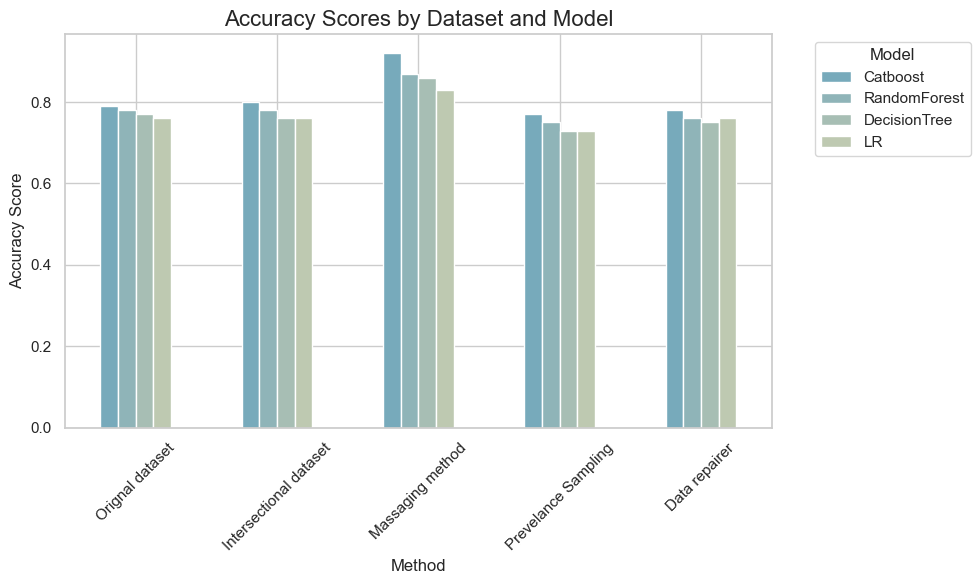

In [55]:

index = 4 
plt.figure(figsize=(10, 6))
accuracy_scores = {}
accuracy_scores["Orignal dataset"] = {"Catboost": 0.79, "RandomForest":0.78, "DecisionTree":0.77, "LR":0.76}
accuracy_scores["Intersectional dataset"] = {"Catboost": 0.8, "RandomForest":0.78, "DecisionTree":0.76, "LR":0.76}
accuracy_scores["Massaging method"] = {"Catboost": 0.92, "RandomForest":0.87, "DecisionTree":0.86, "LR":0.83}
accuracy_scores["Prevelance Sampling"] = {"Catboost": 0.77, "RandomForest":0.75, "DecisionTree":0.73, "LR":0.73}
accuracy_scores["Data repairer"] = {"Catboost": 0.78, "RandomForest":0.76, "DecisionTree":0.75, "LR":0.76}

accuracy_df = pd.DataFrame(accuracy_scores).T
# Set the plot style
sns.set(style="whitegrid")
sns.set_palette("blend:#7AB,#EDA")
# Plot each method's accuracy scores
accuracy_df.plot(kind='bar', figsize=(10, 6))

# Add title and labels
plt.title("Accuracy Scores by Dataset and Model", fontsize=16)
plt.xlabel("Method", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

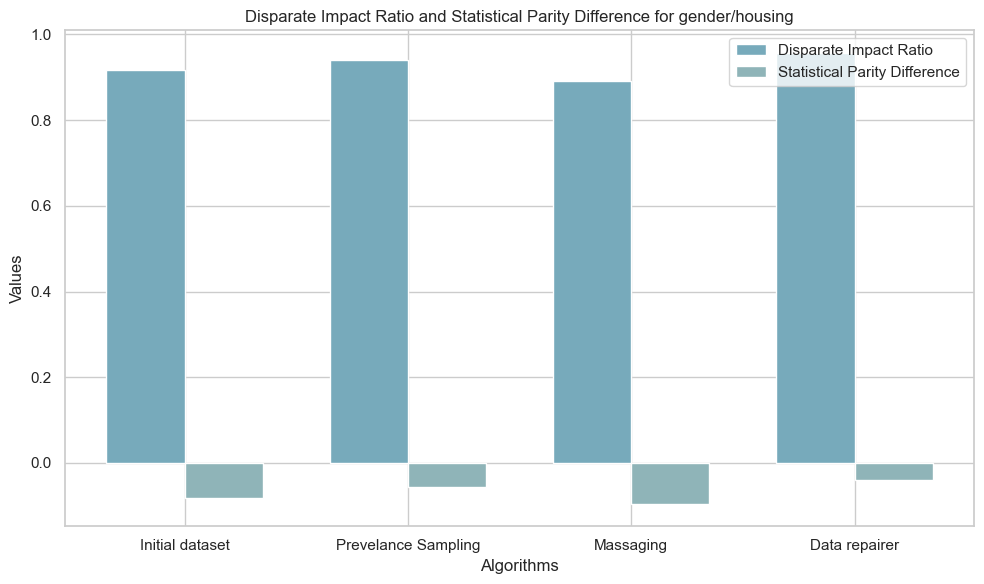

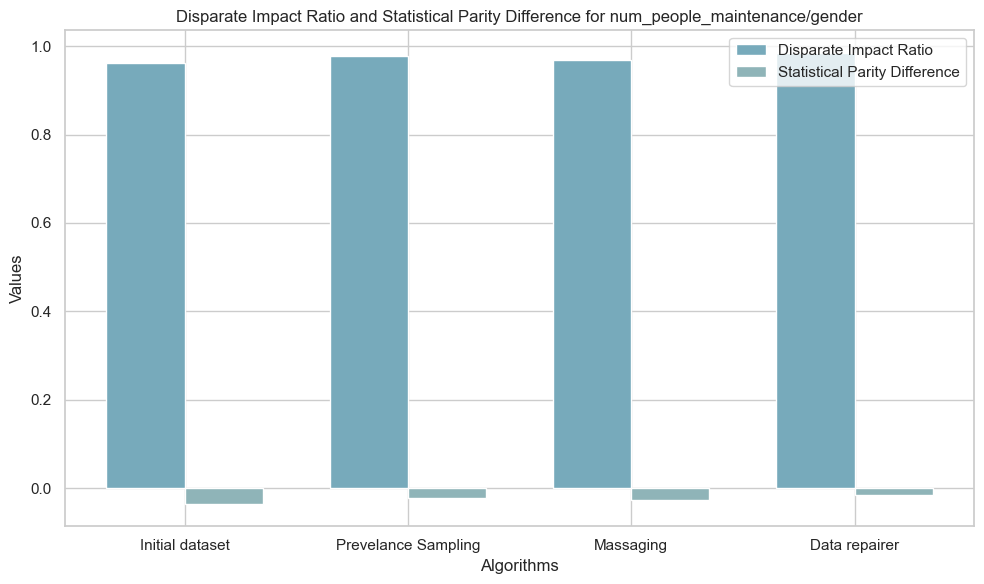

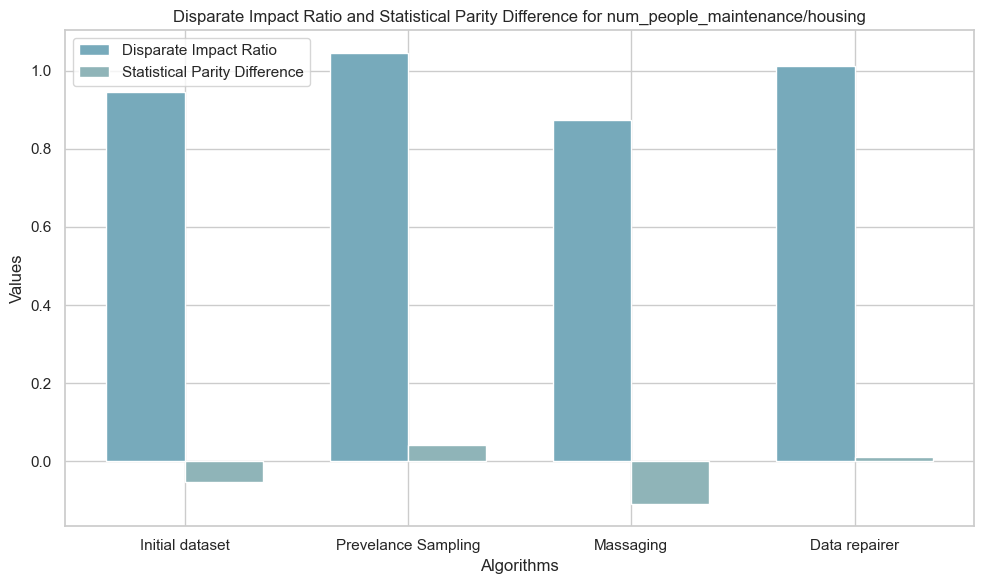

In [57]:
metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['gender/housing']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['gender/housing']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['gender/housing']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['gender/housing']
plot_metrics(metrics_rf,'gender/housing')

metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['num_people_maintenance/gender']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['num_people_maintenance/gender']
plot_metrics(metrics_rf,'num_people_maintenance/gender')

metrics_rf = {}
metrics_rf["Initial dataset"] = metrics_dict_int["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Prevelance Sampling"] = metrics_ps_dict["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Massaging"] = metrics_ms_dict["RandomForest"]['num_people_maintenance/housing']
metrics_rf["Data repairer"] = metrics_dr_dict["RandomForest"]['num_people_maintenance/housing']
plot_metrics(metrics_rf,'num_people_maintenance/housing')